## Inception Score (IS) and Frechet Inception Distance (FID)

Both the Inception Score (or IS) and the Frechet Inception Distance (or FID) are metrics to assess the quality of images generated by a GAN. 

### Generated data

To calculate the Inception Score and the Frechet Inception Distance, we are going to use some generated samples from the previous exercise. The `samples.pickle` contains 800 samples recorded over 50 epochs (16 samples per epoch). We can visualize them below. The samples are saved as `np.array` and contain images in the [0, 255] range.

In [1]:
import pickle
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import torch
import random

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True

In [3]:
# helper function for visualization.

def view_samples(epoch: int, samples: List[np.array]):
    i = 0
    fig, axes = plt.subplots(figsize=(14,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[16 * epoch: 16 * (epoch + 1)]):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        if i==0:
            print(img.shape)
            print(np.transpose(img, (1,2,0)))
        i +=1
        im = ax.imshow(img.reshape((32,32,3)))
    plt.show()

In [4]:
with open('samples.pkl', 'rb') as f:
    samples = pickle.load(f)

In [5]:
print(len(samples))
print(samples[0].shape)

800
(32, 32, 3)


In [6]:
# with open('../train_samples2.pkl', 'rb') as f:
# with open('../GAN_output.pkl', 'rb') as f:
with open('../LSGAN_output.pkl', 'rb') as f:

    mysamples = pickle.load(f)
npsamples = []
for s in mysamples:
    mean = 0.5
    std = 0.5
    s = ((s * std + mean)*255).round().clamp(0, 255).to(torch.uint8)
    npsamples.append(np.transpose(s.to('cpu'), (1,2,0)).numpy())

In [7]:
print(len(npsamples))
print(npsamples[0].shape)
samples = npsamples

800
(32, 32, 3)


(32, 32, 3)
[[[140 142 141 ... 133 142 133]
  [125 126 118 ... 109 110 115]
  [ 78  75  62 ...  62  64  88]]

 [[151 150 143 ... 136 136 139]
  [123 118 120 ... 115 113 111]
  [ 72  68  68 ...  59  64  71]]

 [[149 150 151 ... 125 137 140]
  [117 125 123 ... 114 111 113]
  [ 73  73  73 ...  59  63  78]]

 ...

 [[165 166 162 ... 137 134 154]
  [148 153 138 ... 129 109 129]
  [ 90  89  82 ...  55  53  68]]

 [[167 169 161 ... 145 138 152]
  [147 154 146 ... 127 114 129]
  [100  96  86 ...  57  54  74]]

 [[158 171 164 ... 158 147 161]
  [141 147 137 ... 130 116 126]
  [107 100  94 ...  64  70  91]]]


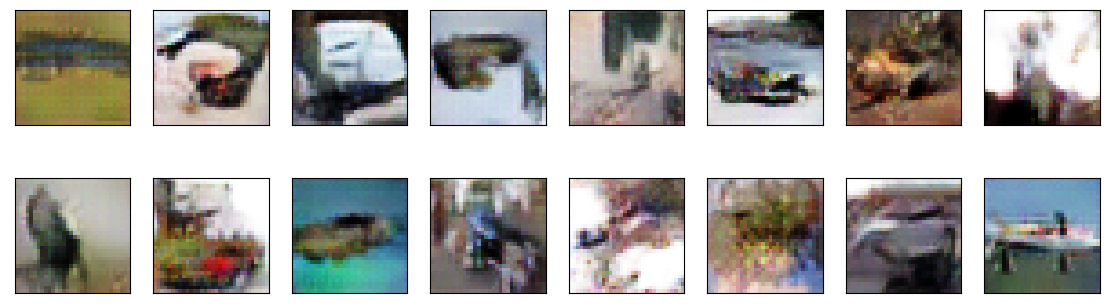

In [8]:
view_samples(0, samples)

### Inception score

The Inception Score was introduced by the [Improved Techniques for Training GANs](https://arxiv.org/pdf/1606.03498.pdf) paper. This metric relies on the following approach:
* generated images are fed through the [Inception model](https://arxiv.org/pdf/1409.4842.pdf) pretrained on the ImageNet dataset. For each image, we get a probability distribution over the 1,000 classes of ImageNet.
* the probability distribution for each image should have [low-entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)). In other words, the model should output high probabilities for a single class and be confident that the image contains one object. We call this distribution the **conditional label distribution**.
* the probability distribution of all the classes over the whole dataset should have high entropy, meaning that the generative model creates images with high variability. We call this distribution the **marginal distribution**.


The inception score is calculated using the [Kullback–Leibler Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) (KL Divergence). 

<img src='assets/kl_divergence.png' width=50% />

The KL divergence is a measure of how two distributions are similar. Since we want the conditional label distribution to have [low entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) (think of a very low spread gaussian for example) and the marginal distribution to have high entropy (think uniform distribution), we want to **maximize the KL divergence**. 

<img src='assets/fid_score.png' width=90% />


[This article](https://medium.com/octavian-ai/a-simple-explanation-of-the-inception-score-372dff6a8c7a) explains the inception score in great depth. 

<br>
<br>
<details>
<summary>
<font size="3" color="black">
<b>Click for tips</b>
</font>
</summary>

* the inception_v3 pytorch model outputs the logits, not the probability and you will need to use the softmax activation to get probabilities.
* look at the [scipy.stats.entropy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html) function for the kl divergence calculation.
* you can find the pytorch Inception_v3 model [here](https://pytorch.org/hub/pytorch_vision_inception_v3/). Don't forget to reshape the inputs! 
* if you are stuck, you can find the pytorch implementation of the inception score from the authors of the paper [here](https://github.com/openai/improved-gan/blob/master/inception_score/model.py).
</details>


#### Notes:
In the original paper, they recommend to use 10 splits and calculate the mean and standard deviation of the score over the 10 splits. They also recommend to use large datasets (over 50k images). Here, we are using a small dataset and therefore will not take the split approach.

In [9]:
len(samples)

800

In [10]:
import torch
from PIL import Image
from torchvision import transforms
from torchvision.models.inception import inception_v3, Inception_V3_Weights
from scipy.stats import entropy

In [11]:
samples_tensor = [torch.from_numpy(arr).float() for arr in samples]
samples_tensor = torch.stack(samples_tensor)
samples_tensor = np.transpose(samples_tensor, (0, 3, 1, 2))
samples_tensor.shape

torch.Size([800, 3, 32, 32])

In [12]:
samples_tensor[0].shape

torch.Size([3, 32, 32])

In [13]:
# samples_tensor = (samples_tensor*255)
# samples_tensor.min()

In [14]:
transform = transforms.Compose([
    transforms.Lambda(lambda x: x/255.0), # I need to transform values to be within 0..1 which normally ToTensor() will do it.
    transforms.Resize(299),
    transforms.CenterCrop(299),
    # transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_batch = transform(samples_tensor);

In [15]:
input_batch.shape
input_batch[0].min()

tensor(-1.4543)

(299, 299, 3)


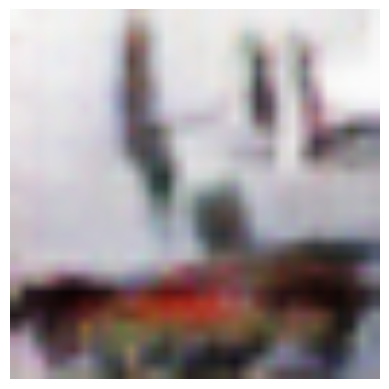

In [16]:
import matplotlib.pyplot as plt

# Transpose the dimensions to match the expected format for imshow

image = input_batch[758].clone()
image = image.detach().cpu().numpy()
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
for i in range(3):  # Iterate over each channel
    image[ i, :, :] = image[i, :, :] * std[i] + mean[i] # rescale to pixel range (0-255)
image = np.transpose(image, (1, 2, 0))
print(image.shape)
# Display the image using imshow
plt.imshow(image)
plt.axis('off')
plt.show()

In [17]:
model = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, transform_input=False)
model.eval()
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

In [18]:
with torch.no_grad():
    scores = model(input_batch)

In [19]:
# del(model)
# torch.cuda.empty_cache()


In [20]:
(scores.shape)

torch.Size([800, 1000])

In [21]:
probabilities = torch.nn.functional.softmax(scores.detach(), dim=1).to('cpu').numpy()

In [22]:
print(probabilities[0, :].max())

0.16886538


In [23]:
probabilities.shape

(800, 1000)

In [24]:
from tqdm import tqdm
def calculate_scores(samples: List[np.array]) -> List[torch.Tensor]:
    """
    This function calculates the score for each sample.
    
    args:
    - samples: list of images to be fed to the inception mode
    
    returns:
    - scores: list containing a score for each sample image
    """
    # load model
    inception_model = inception_v3(pretrained=True, transform_input=False)
    inception_model.eval()
    inception_model.cuda()
    
    # preprocessing
    preprocess = transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])    
    
    # forward pass
    scores = []
    i = 0
    for image in tqdm(samples):
        if i==0:
            image = Image.fromarray(image)
            input_tensor = preprocess(image)
            input_batch = input_tensor.unsqueeze(0).cuda()
            output = model(input_batch)
            probs = torch.nn.functional.softmax(output[0].cpu().detach(), dim=0)
            scores.append(probs.numpy())
            break
        i += 1
    return scores, image

In [25]:
scores, image = calculate_scores(samples)

/usr/local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/800 [00:00<?, ?it/s]


In [26]:
scores[0].max()

0.18126641

In [27]:
print(np.array(image).shape)
print(input_batch[0].shape)

(32, 32, 3)
torch.Size([3, 299, 299])


using PIL image then change to tensro using transform OR change to tensor then divide by 255 and use transform will result in slightly different values for the image but it looks like it is negligible.

In [28]:
# input_batch[0] == image  # the raw image is equal. # after transform they are different

In [29]:
type(probabilities)
probabilities.shape

(800, 1000)

In [30]:
marginal_prob = np.mean(probabilities,axis=0)

In [31]:
marginal_prob.shape

(1000,)

In [32]:
entropy(probabilities, marginal_prob)[0]
# 0.5616283

1.2932738

this method is wrong. you should use loop to calculate individual entropy then take the mean 

In [33]:
np.exp(entropy(probabilities, marginal_prob).mean()) # this method is wrong. you should use loop to calculate individual entropy then take the mean 

2.5923722

In [34]:
def get_inception_score(scores: List[np.array]):
    total_scores = []
    py = np.mean(scores, axis=0)

    # calculate the kl divergence
    kl = []
    for pyx in scores:
        ent = entropy(pyx, py)
        kl.append(ent)
    return kl, np.exp(np.mean(kl))

In [35]:
kl, inception_score = get_inception_score(probabilities)
print(f"Inception Score: {inception_score}")
# print(kl[0])
# Inception Score: 3.3337514400482178

Inception Score: 4.114542007446289


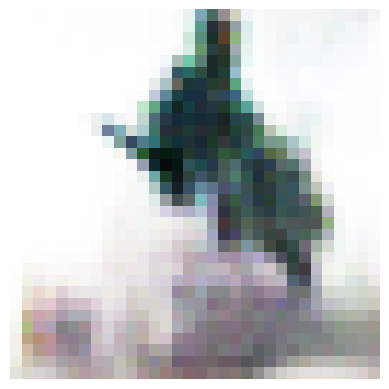

torch.return_types.topk(
values=tensor([0.9095, 0.0356, 0.0175]),
indices=tensor([152, 157, 188]))
Japanese Chin


In [36]:
def show_image(image):
    # image = input_batch[99].clone()
    # image = image.detach().cpu().numpy()
    # mean = [0.485, 0.456, 0.406]
    # std = [0.229, 0.224, 0.225]
    # for i in range(3):  # Iterate over each channel
    #     image[ i, :, :] = image[i, :, :] * std[i] + mean[i] # rescale to pixel range (0-255)
    # image = np.transpose(image, (1, 2, 0))
    # print(image.shape)
    # # Display the image using imshow
    plt.imshow(image)
    plt.axis('off')
    plt.show()

index = (27*16)+10
index = 355
show_image(samples[index])


import requests, json

prob_tensor = torch.tensor(probabilities)
print(torch.topk(prob_tensor[index], 3))
_, predicted_labels = torch.max(prob_tensor, 1)

# Get the label names
with open('imagenet_labels.json') as f:
    labels = json.load(f)

# Get the predicted label name
predicted_label_name = labels[predicted_labels[index].item()]

print(predicted_label_name)

In [37]:
print("top 3 probable labels: ")
for ind in torch.topk(prob_tensor[index], 3).indices:
    print(labels[ind])

top 3 probable labels: 
Japanese Chin
Papillon
Wire Fox Terrier


[(510, 0.9791185259819031), (103, 0.9497014284133911), (392, 0.9404396414756775), (152, 0.9095054268836975), (275, 0.8955468535423279), (275, 0.8844952583312988), (347, 0.8725982308387756), (510, 0.872282087802887), (413, 0.8606906533241272), (856, 0.8365665078163147)]


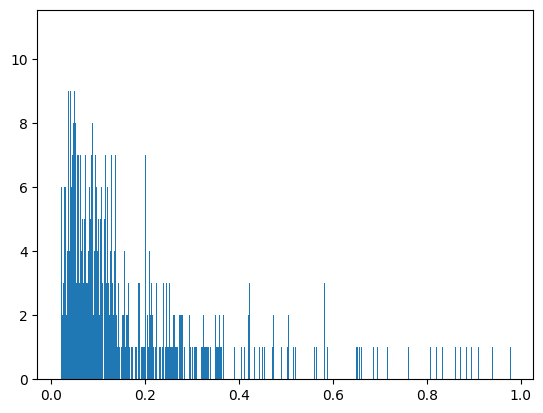

In [38]:
all_probs = []
dict_probs = {}
for i in range(len(samples)):
    top1 = torch.topk(prob_tensor[i], 1)
    all_probs.append((top1.indices.item(), top1.values.item()))
    dict_probs[i] = top1.values.item()

sorted_probs = sorted(all_probs, reverse=True, key=lambda x: x[1])
dict_probs = sorted(dict_probs.items(), key=lambda x: x[1])


plt.hist([value for _, value in sorted_probs], bins=len(samples));
print(sorted_probs[:10])

In [39]:
tmp_sample=[]
for key, value in dict_probs:
    if value > 0.6:
        print(key, value)
        tmp_sample.append(samples[key])
        

752 0.6118108034133911
525 0.6141929626464844
24 0.6214733719825745
49 0.6444258093833923
323 0.6506216526031494
651 0.6528810858726501
580 0.6570815443992615
171 0.6618327498435974
225 0.6719146370887756
291 0.6722552180290222
629 0.6869207620620728
339 0.6916029453277588
347 0.6957340240478516
710 0.6989070177078247
300 0.7154757976531982
193 0.7165260910987854
252 0.717850923538208
612 0.7264869213104248
473 0.7404346466064453
558 0.761580228805542
82 0.7793316841125488
350 0.8082684278488159
358 0.8195685744285583
712 0.8217856287956238
71 0.8232486844062805
660 0.8335015773773193
598 0.8365665078163147
444 0.8606906533241272
680 0.872282087802887
593 0.8725982308387756
269 0.8844952583312988
561 0.8955468535423279
355 0.9095054268836975
265 0.9404396414756775
417 0.9497014284133911
735 0.9791185259819031


(32, 32, 3)
[[[255 255 255 ... 242 237 225]
  [255 255 255 ... 240 237 227]
  [255 255 255 ... 235 223 220]]

 [[254 255 254 ... 210 210 217]
  [255 255 255 ... 186 200 214]
  [255 255 255 ... 162 183 206]]

 [[254 254 255 ... 179 190 216]
  [254 255 255 ... 154 183 208]
  [255 255 255 ... 142 174 211]]

 ...

 [[241 245 242 ... 144 188 219]
  [239 246 247 ... 145 177 215]
  [242 249 247 ... 146 170 210]]

 [[237 243 246 ... 144 174 216]
  [236 243 246 ... 149 177 204]
  [241 245 249 ... 146 171 207]]

 [[243 250 252 ... 155 172 202]
  [244 250 251 ... 145 163 190]
  [246 251 252 ... 145 168 188]]]


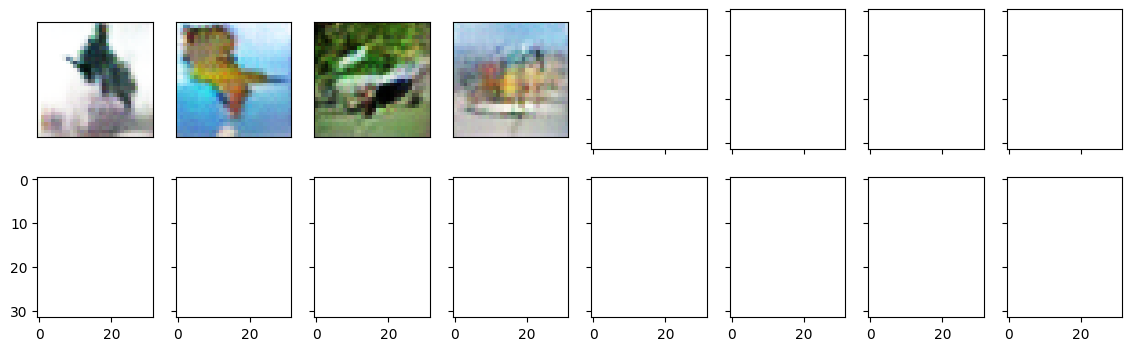

In [43]:
view_samples(0, tmp_sample[16*2:])

### Frechet Inception Distance

The Frechet Inception Distance was first introduced by the [GANs Trained by a Two Time-Scale Update Rule
Converge to a Local Nash Equilibrium](https://arxiv.org/pdf/1706.08500.pdf) paper. 

The Inception Score was a groundbreaking metric for measure GAN performances but it has a major flaw: **it does not take into account the statistics of the "real" dataset the GAN is supposed to mimic and only uses the generated images.**

The FID takes a different approach:
* for each image in the generated dataset **and** the target (real) dataset, get the latent representation by running the Inception model. The latent representation of each image is the output of the penultimate layer, before the final classification layer.
* calculate the mean and the covariance of the real distribution ($m_{r}$ and $C_{r}$)
* calculate the mean and the covariance of the generated distribution ($m_{g}$ and $C_{g}$)
* calculate the Frechet Distance defined below:

$FID = ||m_{r} - m_{g}||^{2}_{2} + Tr(C_{r}) + Tr(C_{g}) - 2 Tr(C_{r}C_{g})^{1/2}$

where $||.||_{2}$ is the L-2 norm and $Tr$ the trace of the covariance matrices. 


In this exercise, we will simply ask you to implement the FID calculation, assuming that you already have calculated the mean and covariance of both distribution.

<br>
<br>
<details>
<summary>
<font size="3" color="black">
<b>Click for tips</b>
</font>
</summary>

* you can calculate the trace of the covariance matrices using `np.trace`
</details>

In [40]:
from scipy import linalg

In [41]:
def get_fid(mu1: np.array, sigma1: np.array, mu2: np.array, sigma2: np.array):
    """
    Calculate the FID. 
    """
    diff = mu1 - mu2
    
    # calculate the square root of the dot product of the covariance matrices
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    
    # calculate the trace
    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1)
            + np.trace(sigma2) - 2 * tr_covmean)

In [42]:
samples1 = np.random.randn(100, 2048)
mu1 = np.mean(samples1, axis=0)
sigma1 = np.cov(samples1)

samples2 = np.random.randn(100, 2048)
mu2 = np.mean(samples2, axis=0)
sigma2 = np.cov(samples2)

In [43]:
fid = get_fid(mu1, sigma1, mu2, sigma2)
print(fid)

42.20000302935486
